In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.integrate import quad
from scipy.fft import fft, ifft
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from functools import partial
from scipy.optimize import minimize, fsolve, basinhopping
import tqdm
import yfinance as yf
import yahoo_fin.options as ops
import cmath

%matplotlib inline

plt.style.use('ggplot')
sns.set_palette('mako')
sns.set_style('darkgrid')

In [2]:
import exact_methods as exm
import characteristics_functions as chf
import monte_carlo_methods as mcm
import stochastic_processes as stch

In [25]:
expiration_dates = ops.get_expiration_dates("aapl")

In [26]:
expiration_dates

['April 29, 2022',
 'May 6, 2022',
 'May 13, 2022',
 'May 20, 2022',
 'May 27, 2022',
 'June 3, 2022',
 'June 17, 2022',
 'July 15, 2022',
 'August 19, 2022',
 'September 16, 2022',
 'October 21, 2022',
 'November 18, 2022',
 'January 20, 2023',
 'March 17, 2023',
 'June 16, 2023',
 'September 15, 2023',
 'January 19, 2024',
 'June 21, 2024']

In [27]:
# s0_apple = 150.62 #15.03.2022
apple = yf.Ticker('AAPL')
s0 = apple.history().iloc[-1, 3]
s0

156.57000732421875

In [28]:
apple_option_calls = ops.get_puts("AAPL", expiration_dates[6])

In [29]:
apple_option_calls.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,AAPL220617P00028750,2022-03-14 9:38AM EDT,28.75,0.01,0.0,0.00,0.0,-,1,1636,50.00%
1,AAPL220617P00030000,2022-04-01 3:30PM EDT,30.00,0.01,0.0,0.00,0.0,-,50,2811,50.00%
2,AAPL220617P00031250,2022-02-08 10:30AM EDT,31.25,0.02,0.0,0.06,0.0,-,2,440,153.91%
3,AAPL220617P00032500,2022-03-22 11:12AM EDT,32.50,0.02,0.0,0.02,0.0,-,1,514,135.94%
4,AAPL220617P00033750,2022-03-08 12:05PM EDT,33.75,0.03,0.0,0.04,0.0,-,8,394,141.41%


In [30]:
# apple_option_calls.to_csv('apple_option_put_june_17_2022_s0_156_57.csv')

In [31]:
# apple_option_calls.head()

In [32]:
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [33]:
apple_spread = apple_option_calls.loc[:, 'Ask'] - apple_option_calls.loc[:, 'Bid']

In [3]:
from datetime import datetime

In [35]:
expr_date = datetime.strptime(expiration_dates[6], '%B %d, %Y')
expr_date

datetime.datetime(2022, 6, 17, 0, 0)

In [36]:
today_date = datetime.now()
today_date

datetime.datetime(2022, 4, 28, 15, 56, 5, 747878)

In [37]:
maturity = expr_date - today_date
maturity = maturity.days/365.25
maturity

0.13415468856947296

In [38]:
(expr_date - today_date).days

49

In [5]:
apple_option_calls = pd.read_csv('apple_option_put_may_06_2022.csv')
apple_strikes = apple_option_calls.loc[:, 'Strike']
apple_market_price = apple_option_calls.loc[:, 'Last Price']

In [6]:
expr_date = datetime.strptime('May 06, 2022', '%B %d, %Y')

In [7]:
maturity = expr_date - datetime.strptime('April 10, 2022', '%B %d, %Y')
maturity = maturity.days/365.25
maturity

0.07118412046543464

In [8]:
N = 500
T = maturity
r = 0.05
rho1 = 0.01
s0 = 174.62

# type_option = 'c'
type_option = 'p'

In [9]:
# r, kappa, gamma, vbar, v0, rho

def error_fHM(x, prices, strikes, s0):
    cf = chf.ChFHestonModel(x[0], 1, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], T, strikes, N, 8).T[0]
#     errorVector = (price_calib - prices)
    errorVector = np.mean(((price_calib - prices))**2)
    
#     value = np.linalg.norm(errorVector)
    value = errorVector
    return value

In [10]:
init_vals = [0.05, 2, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.001, 0.3), (0.001, 4), (0.0001, 2), (0.0001, 1.5), (0.0001, 1.5), (-0.9, 0.9))

# P0T = lambda T: np.exp(0.0012*T+0.0007) 
# s0 = 174.62

# referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
# T = 5/365.25
# referenceIV = np.array([36.76, 29.18, 27.66])/100.0
    
# frwd = s0/P0T(T)
# K = [0.4*frwd, frwd, 1.2*frwd]
# K = np.array(K).reshape([len(K),1])
      
# referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])
# marketPrice = P0T(T)* exm.BS_Call_Option_Price('c', s0 / P0T(T), K, referenceIV, T, 0)


# params_heston_COS = minimize(error_fHM, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, apple_spread),
#                              bounds=bounds, tol=1e-4, options={"maxiter": 1000})

K = apple_strikes
marketPrice = apple_market_price

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(marketPrice, K, s0),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

      fun: 6.738007659465959
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 52.71571582,  -0.69643109,  32.79140088, -35.89964639,
       -23.26907538,  -2.06011848])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 196
      nit: 11
     njev: 28
   status: 0
  success: True
        x: array([ 2.41553765e-01,  2.28363556e+00,  1.00000000e-04,  1.65062710e-01,
        1.00000000e-04, -4.99254886e-01])

In [11]:
np.sqrt(params_heston_COS.fun)

2.595767258339229

In [12]:
r, kappa, gamma, vbar, v0, rho = params_heston_COS.x

In [13]:
cf = chf.ChFHestonModel(r, 1, kappa, gamma, vbar, v0, rho)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, 10).T[0]

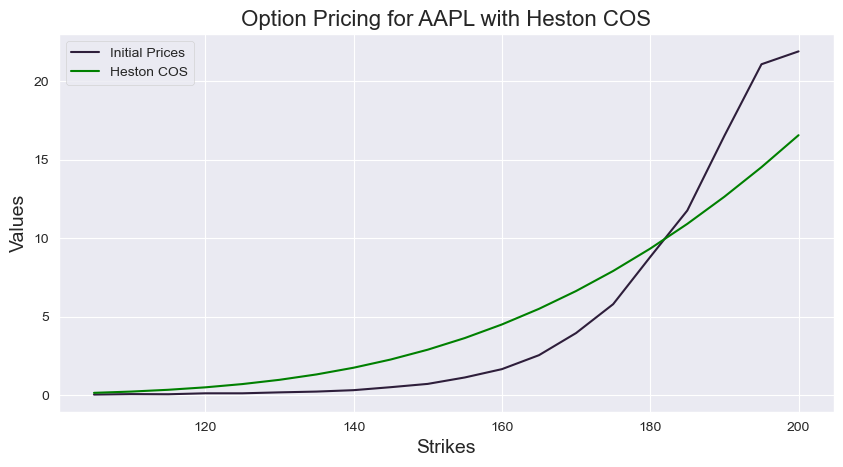

In [14]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_heston_cos, color='green', label='Heston COS')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [50]:
def calibrationBates_SIR_SC(CP, K, marketPrice, s0, T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    
    # x = [k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0, muJ, sigmaJ]
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], x[10], x[3], x[4], x[11], x[5], x[6], x[7], x[8], x[16], x[14],
                               x[15], x[9], x[13], x[12], K, marketPrice, s0)

    #[k, gamma, vb, gammar, mur, murho, sigmarho, rho4, rho5, v0, kr, krho, rho0, r0, muJ, sigmaJ]
    initial = np.array([0.4, 0.3, 0.04, 0.3, 0.1, 0.2, 0.5, 0.1, 0.1, 0.05, 0.4, 0.5, -0.7, 0.001, 0, 1, 0.05])
#     pars  = minimize(f_obj, initial, method='nelder-mead', options = {'xtol': 1e-05, 'disp': False,'maxiter':1000})
    
    xmin = [0.001, 0.0001, 0.0001, 0.0005, 0.001, 0.0001, 0.0005, -0.99, -0.99, 0.0001, 0.0001, 0.4, -1, 0.0001, -10, 0.0001, 0.0001]
#     xmax = [2, 0.3, 0.4, 0.3, 0.4, 0.4, 0.2, 0.8, 0.8, 0.3, 0.99, 0.99]  
    xmax = [5, 0.7, 1.5, 2, 3, 2, 1, 0.6, 0.9, 1.7, 4, 5, 1, 0.3, 10, 15, 5] 
    
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    
    pars  = minimize(f_obj, x0=initial, tol=1e-8, bounds=bounds, options = {'maxiter': 200, 'disp':False})
#     pars  = minimize(f_obj, x0=initial, method='nelder-mead', tol=1e-6, options = {'maxiter': 100, 'disp':False})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    gammar_est = pars.x[3]
    mur_est = pars.x[4]
    murho_est = pars.x[5]
    sigmarho_est = pars.x[6]
    rho4_est = pars.x[7]
    rho5_est = pars.x[8]
    v0_est = pars.x[9]
    kr_est = pars.x[10]
    krho_est = pars.x[11]
    rho0_est = pars.x[12]
    r0_est = pars.x[13]
    muJ_est = pars.x[14]
    sigmaJ_est = pars.x[15]
    xip_est = pars.x[16]
    
    parmCalibr =  {"k":k_est, "gamma":gamma_est, "vb":vb_est, "gammar":gammar_est, "mur":mur_est, "murho":murho_est, \
                   "sigmarho":sigmarho_est, "rho4":rho4_est, "rho5": rho5_est, "v0":v0_est, "kr": kr_est, "krho": krho_est, \
                   "rho0": rho0_est, "r0": r0_est, "muJ": muJ_est, "sigmaJ": sigmaJ_est, 'xip': xip_est, 'ErrorFinal':pars.fun}
    return parmCalibr

In [51]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    N = 500
    L = 10
    cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L)

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
#     errorVector = valCOS - marketPrice
    value = errorVector
#     value = np.linalg.norm(errorVector)

    return value

In [52]:
T = maturity
tau = T
s0 = 174.62
xip = 0.05
type_option = 'p'

# P0T = lambda T: np.exp(0.0005*T)

K = apple_strikes

marketPrice = apple_market_price

calibratedParms =  calibrationBates_SIR_SC(type_option, K, marketPrice, s0, T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
murho = calibratedParms.get('murho')
sigmarho = calibratedParms.get('sigmarho')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')
xip = calibratedParms.get('xip')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 0.36674481907337037
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.99672500e-03,  2.51686394e-02,  6.07344909e+00,  4.91212626e-04,
        1.88182803e-06, -1.05471187e-07, -5.55111513e-09, -6.66133815e-08,
        1.17063581e-03,  2.59512051e-01,  6.70191680e-04,  4.44089208e-08,
       -5.26800823e-06, -6.40057840e-02,  5.95988259e-03,  8.37205865e-03,
        4.05200484e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 972
      nit: 35
     njev: 54
   status: 0
  success: True
        x: array([ 6.13106467e-01,  1.00000000e-04,  1.00000000e-04,  3.01547510e-01,
        1.00046233e-01,  2.01665863e-01,  4.98730558e-01,  8.63268599e-02,
        1.04603038e-01,  1.49728385e-01,  3.98959312e-01,  5.03447786e-01,
       -5.15652028e-01,  2.96491762e-01,  4.45546366e-02,  1.16928656e+00,
        8.41664847e-02])


In [53]:
np.sqrt(errorFinal)

0.6055945996071715

In [54]:
round(errorFinal, 9)

0.366744819

In [55]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

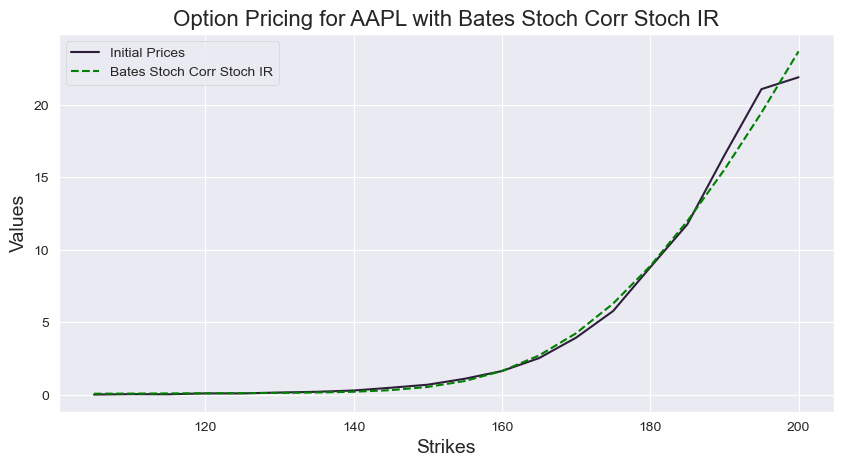

In [56]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch Corr Stoch IR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [57]:
print(f'r0: {r0}, v0: {v0}, rho0: {rho0}, muJ: {muJ}, sigmaJ: {sigmaJ}')

r0: 0.29649176236776104, v0: 0.1497283850640319, rho0: -0.5156520280983252, muJ: 0.04455463656869957, sigmaJ: 1.1692865614573635


In [58]:
np.mean((marketPrice.values - valCOS.T[0])**2)

0.36674481907337037

In [59]:
list_params = np.array([v0, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, muJ, sigmaJ, r0, rho0, xip])
pd.DataFrame(list_params.reshape(1, -1), columns=['v0', 'k', 'gamma', 'vb', 'kr', 'gammar', 'mur', 'krho', 'murho', 'sigmarho', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xip'])

,v0,k,gamma,vb,kr,gammar,mur,krho,murho,sigmarho,rho4,rho5,muJ,sigmaJ,r0,rho0,xip
0,0.149728,0.613106,0.0001,0.0001,0.398959,0.301548,0.100046,0.503448,0.201666,0.498731,0.086327,0.104603,0.044555,1.169287,0.296492,-0.515652,0.084166


Optimal parameters for H1-HW are: gamma = 0.780, vBar = 0.027, Rxv = -0.990, v0 = 0.105
Final error for H1HW = 0.658647123


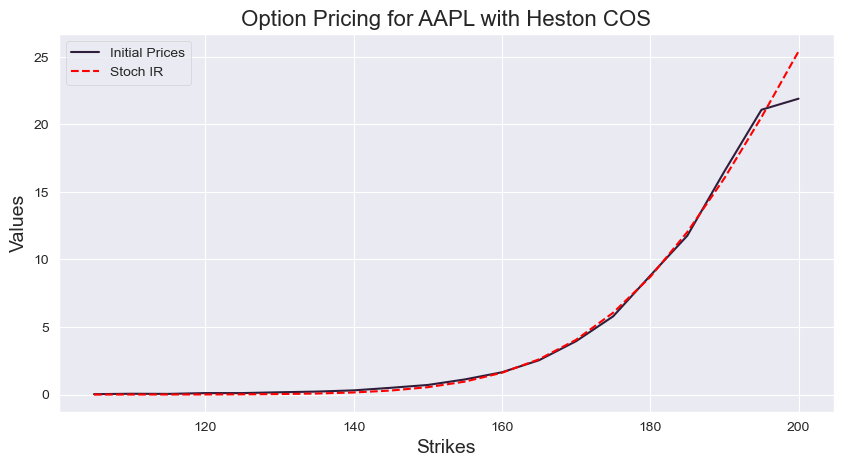

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.stats as st
import scipy.special as sp
import enum 
import scipy.optimize as optimize
from scipy.optimize import minimize

i   = complex(0.0,1.0)

# Time step 
dt = 0.0001

class OptionType(enum.Enum):
    CALL = 1.0
    PUT = -1.0
    
def CallPutOptionPriceCOSMthd_StochIR(cf,CP,S0,tau,K,N,L,P0T):


    # cf   - Characteristic function is a function, in the book denoted by \varphi
    # CP   - C for call and P for put
    # S0   - Initial stock price
    # tau  - Time to maturity
    # K    - List of strikes
    # N    - Number of expansion terms
    # L    - Size of truncation domain (typ.:L=8 or L=10)
    # P0T  - Zero-coupon bond for maturity T.

    # Reshape K to become a column vector

    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Assigning i=sqrt(-1)

    i = complex(0.0,1.0) 
    x0 = np.log(S0 / K)   
    
    # Truncation domain

    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)
    
    # Summation from k = 0 to k=N-1

    k = np.linspace(0,N-1,N).reshape([N,1])  
    u = k * np.pi / (b - a)  

    # Determine coefficients for put prices  

    H_k = CallPutCoefficients(OptionType.PUT,a,b,k)   
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k 
    temp[0] = 0.5 * temp[0]    
    value = K * np.real(mat.dot(temp))     
    
    # We use the put-call parity for call options

    if CP == OptionType.CALL:
        value = value + S0 - K * P0T
        
    return value

# Determine coefficients for put prices 

def CallPutCoefficients(CP,a,b,k):
    if CP==OptionType.CALL:                  
        c = 0.0
        d = b
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        if a < b and b < 0.0:
            H_k = np.zeros([len(k),1])
        else:
            H_k      = 2.0 / (b - a) * (Chi_k - Psi_k)  
    elif CP==OptionType.PUT:
        c = a
        d = 0.0
        coef = Chi_Psi(a,b,c,d,k)
        Chi_k = coef["chi"]
        Psi_k = coef["psi"]
        H_k      = 2.0 / (b - a) * (- Chi_k + Psi_k)               
    
    return H_k    

def Chi_Psi(a,b,c,d,k):
    psi = np.sin(k * np.pi * (d - a) / (b - a)) - np.sin(k * np.pi * (c - a)/(b - a))
    psi[1:] = psi[1:] * (b - a) / (k[1:] * np.pi)
    psi[0] = d - c
    
    chi = 1.0 / (1.0 + np.power((k * np.pi / (b - a)) , 2.0)) 
    expr1 = np.cos(k * np.pi * (d - a)/(b - a)) * np.exp(d)  - np.cos(k * np.pi 
                  * (c - a) / (b - a)) * np.exp(c)
    expr2 = k * np.pi / (b - a) * np.sin(k * np.pi * 
                        (d - a) / (b - a))   - k * np.pi / (b - a) * np.sin(k 
                        * np.pi * (c - a) / (b - a)) * np.exp(c)
    chi = chi * (expr1 + expr2)
    
    value = {"chi":chi,"psi":psi }
    return value
    
# Black-Scholes call option price

def meanSqrtV_3(kappa,v0,vbar,gamma):
    delta = 4.0 *kappa*vbar/gamma/gamma
    c= lambda t: 1.0/(4.0*kappa)*gamma*gamma*(1.0-np.exp(-kappa*(t)))
    kappaBar = lambda t: 4.0*kappa*v0*np.exp(-kappa*t)/(gamma*gamma*(1.0-np.exp(-kappa*t)))
    temp1 = lambda t: np.sqrt(2.0*c(t))* sp.gamma((1.0+delta)/2.0)/sp.gamma(delta/2.0)*sp.hyp1f1(-0.5,delta/2.0,-kappaBar(t)/2.0)
    return temp1

def C_H1HW(u,tau,lambd):
    i = complex(0.0,1.0)
    C = (i*u - 1.0)/lambd * (1-np.exp(-lambd*tau))
    return C

def D_H1HW(u,tau,kappa,gamma,rhoxv):
    i = complex(0.0,1.0)
    
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    D  = (1.0-np.exp(-D1*tau))/(gamma*gamma*(1.0-g*np.exp(-D1*tau)))\
        *(kappa-gamma*rhoxv*i*u-D1)
    return D
    
def A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr):
    i  = complex(0.0,1.0)
    D1 = np.sqrt(np.power(kappa-gamma*rhoxv*i*u,2)+(u*u+i*u)*gamma*gamma)
    g  = (kappa-gamma*rhoxv*i*u-D1)/(kappa-gamma*rhoxv*i*u+D1)
    
    # Function theta(t)

    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    theta = lambda t: 1.0/lambd * (f0T(t+dt)-f0T(t-dt))/(2.0*dt) + f0T(t) + eta*eta/(2.0*lambd*lambd)*(1.0-np.exp(-2.0*lambd*t))  

    # Integration within the function I_1

    N  = 500
    z  = np.linspace(0,tau-1e-10,N)
    f1 = (1.0-np.exp(-lambd*z))*theta(tau-z)
    value1 = integrate.trapz(f1,z)
    
    # Note that I_1_adj also allows time-dependent theta 
    # Therefore it is not exactly the same as in the book

    I_1_adj = (i*u-1.0) * value1
    I_2     = tau/(gamma**2.0) *(kappa-gamma*rhoxv*i*u-D1) - 2.0/(gamma**2.0)*np.log((1.0-g*np.exp(-D1*tau))/(1.0-g))
    I_3     = 1.0/(2.0*np.power(lambd,3.0))* np.power(i+u,2.0)*(3.0+np.exp(-2.0*lambd*tau)-4.0*np.exp(-lambd*tau)-2.0*lambd*tau)
    
    meanSqrtV = meanSqrtV_3(kappa,v0,vbar,gamma)
    f2        = meanSqrtV(tau-z)*(1.0-np.exp(-lambd*z))
    value2    = integrate.trapz(f2,z)
    I_4       = -1.0/lambd * (i*u+u**2.0)*value2
    
    return I_1_adj + kappa*vbar*I_2 + 0.5*eta**2.0*I_3+eta*rhoxr*I_4

def ChFH1HWModel(P0T,lambd,eta,tau,kappa,gamma,vbar,v0,rhoxv, rhoxr):
    dt = 0.0001    
    f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
    r0 =f0T(0.00001)
    C = lambda u: C_H1HW(u,tau,lambd)
    D = lambda u: D_H1HW(u,tau,kappa,gamma,rhoxv)
    A = lambda u: A_H1HW(u,tau,P0T,lambd,eta,kappa,gamma,vbar,v0,rhoxv,rhoxr)
    cf = lambda u: np.exp(A(u) + C(u)*r0 + D(u)*v0 )
    return cf


def calibrationH1HW_Global(CP,K,marketPrice,S0,T,P0T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
    # x = [gamma,vBar,Rxv,v0, eta, kappa, lambda, rxr]
    f_obj = lambda x: TargetValH1HW(CP,x[5],x[0],x[1],x[7],x[2],x[3],x[4],x[6],K,marketPrice,S0,T,P0T)
       
    # Random initial guess

    #[gamma,vBar,Rxv,v0]
    initial = np.array([1.0, 0.05,-0.7, 0.05, 0.01, 0.3, 0.04, 0.4])
    
    # The bounds

    xmin = [0.001, 0.001,-0.99, 0.001, 0.001, 0.001, 0.001, -1]
    xmax = [0.8,  0.8,  -0.3, 0.8, 0.7, 0.7, 0.7, 1]    
    
    # Rewrite the bounds as required by L-BFGS-B

    bounds = [(low, high) for low, high in zip(xmin, xmax)]

    pars  = minimize(f_obj,initial,bounds=bounds, tol=1e-05)
    
    gamma_est = pars.x[0]
    vBar_est = pars.x[1]
    Rxv_est = pars.x[2]
    v0_est = pars.x[3]
    eta = pars.x[4]
    kappa = pars.x[5]
    lambd = pars.x[6]
    rxr = pars.x[7]
    parmCalibr =  {"gamma":gamma_est,"vBar":vBar_est,"Rxv":Rxv_est,\
                   "v0":v0_est, "eta": eta, "kappa": kappa, "lambda": lambd, "rxr": rxr,'ErrorFinal':pars.fun}
    return parmCalibr

def TargetValH1HW(CP,kappa,gamma,vBar,Rxr,Rxv,v0,eta,lambd,K,marketPrice,S0,T,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])
    
    # Settings for the COS method

    N = 500
    L = 10 
    cf = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0, Rxv, Rxr)
    valCOS = CallPutOptionPriceCOSMthd_StochIR(cf, CP, S0, T, K, N, L,P0T(T))
    
    # Error is defined as the difference between the market and the model

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
    
    # Target value is a norm of the error vector

#     value       = np.linalg.norm(errorVector)   
    value = errorVector
    return value

def mainCalculation():
    CP  = OptionType.PUT
    global valCOS_H1HW
        
    S0    = 174.62    
#     S0 = s0


    P0T = lambda T: np.exp(0.0012*T+0.0007)

    N = 500
    L = 10 

    
    T = maturity

    K = apple_strikes
    referencePrice = apple_market_price
    calibratedParms =  calibrationH1HW_Global(CP,K,referencePrice,S0,T,P0T)
    
    gamma = calibratedParms.get('gamma')
    vBar  = calibratedParms.get('vBar')
    Rxv   = calibratedParms.get('Rxv')
    v0    = calibratedParms.get('v0')
    eta = calibratedParms.get('eta')
    kappa = calibratedParms.get('kappa')
    lambd = calibratedParms.get('lambda')
    Rxr = calibratedParms.get('rxr')
    errorH1HW = calibratedParms.get('ErrorFinal')   
    
    cf2 = ChFH1HWModel(P0T,lambd,eta,T,kappa,gamma,vBar,v0,Rxv, Rxr)
    valCOS_H1HW = CallPutOptionPriceCOSMthd_StochIR(cf2, CP, S0, T, K, N, L,P0T(T))
    

    print("Optimal parameters for H1-HW are: gamma = {0:.3f}, vBar = {1:.3f}, Rxv = {2:.3f}, v0 = {3:.3f}".format(gamma,vBar,Rxv,v0))
    print('Final error for H1HW = {0}'.format(round(errorH1HW, 9)))

    plt.subplots(figsize=(10, 5), dpi=100)

    plt.plot(K, apple_market_price, label='Initial Prices')
    plt.plot(K, valCOS_H1HW, '--', color='red', label='Stoch IR')

    plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
    plt.xlabel('Strikes', fontsize=14)
    plt.ylabel('Values', fontsize=14)
    plt.legend()
    plt.show()
    
mainCalculation()

In [29]:
def zcb_curve(tau, kr, mur, gammar, rt):
    p = np.sqrt(kr**2 + 2*gammar**2)
    bfun = (2*(np.exp(p*tau)-1))/(2*p + (np.exp(p*tau)-1)*(p + kr))
    afun = (2*kr*mur)/(gammar**2) * np.log((2*p*np.exp((p+kr)*tau/2))/(2*p + (np.exp(p*tau)-1)*(p + kr)))
    
    return np.exp(afun - bfun*rt)

In [30]:
zcb0 = zcb_curve(tau, kr, mur, gammar, r0)
zcb0

0.9790685115822434

In [31]:
numberPaths = 20000
N = 500
type_option = 'p'

time, S, M = mcm.bates_SC_SIR_AES(numberPaths, N, s0, v0, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5,
                    xip, muJ, sigmaJ, r0, rho0)

In [32]:
option_bates_stoch_AES = mcm.optionPriceMC_Stoch(type_option, S[:, -1], K, T, M[:, -1])

In [33]:
option_bates_stoch_AES_Tm = mcm.optionPriceMC_Stoch_Tm(type_option, S[:, -1], K, T, zcb0)

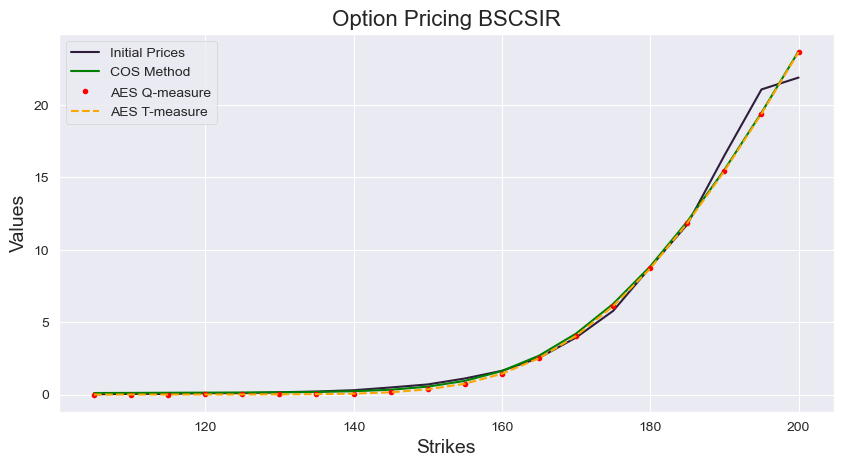

In [34]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(apple_strikes, apple_market_price, label='Initial Prices')
plt.plot(apple_strikes, valCOS, color='green', label='COS Method')
plt.plot(apple_strikes, option_bates_stoch_AES, '.',color='red', label='AES Q-measure')
plt.plot(apple_strikes, option_bates_stoch_AES_Tm, '--',color='orange', label='AES T-measure')
        
plt.title('Option Pricing BSCSIR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [80]:
r0

0.3

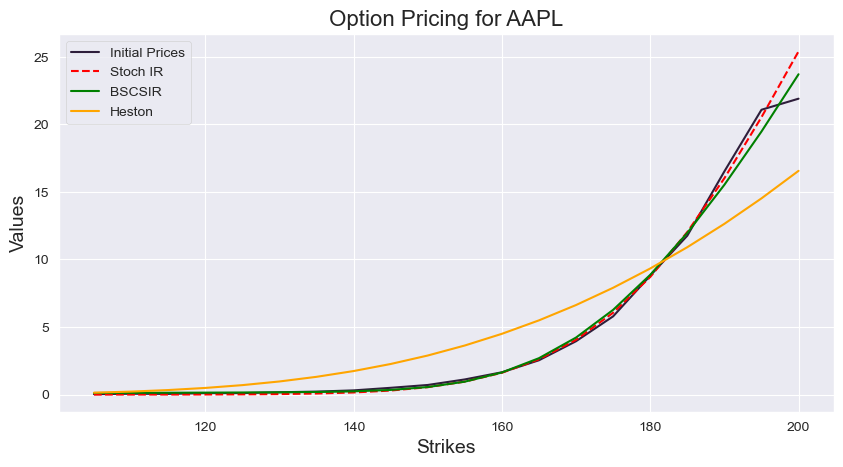

In [35]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, apple_market_price, label='Initial Prices')
plt.plot(K, valCOS_H1HW, '--', color='red', label='Stoch IR')
plt.plot(K, valCOS, color='green', label='BSCSIR')
plt.plot(K, option_heston_cos, color='orange', label='Heston')

plt.title('Option Pricing for AAPL', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [36]:
np.mean((1/M[:, -1]))

0.9790679154855425

In [37]:
zcb0

0.9790685115822434

In [84]:
import numpy as np

In [85]:
dt = 0.0001 
P0T = lambda T: np.exp(0.0012*T+0.0007) 
f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
f0T(0.00001)

-0.0011999999998231958

## BSCSIR with stochastic correlation by DCL process 

In [38]:
def calibrationBates_SIR_SC_DCL(CP, K, marketPrice, s0, T):
    K = np.array(K)
    marketPrice = np.array(marketPrice)
   
    # k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0
    f_obj = lambda x: errorFun(CP, tau, T, x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8], x[9],
                               x[10], x[11], x[12], x[13], x[14], x[15], K, marketPrice, s0)

                        # k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0
    initial = np.array([0.4, 0.3, 0.04, 0.3, 0.2,   0.2,   2,   1.5,  0.1, 0.5, 0.05,  0,    1, 0.04,   0.05, 0.7])

            # k,    gamma,   vb,     kr,   gammar, mur, krho, delta, rho4, rho5,  xip,    muJ, sigmaJ, v0, r0, rho0
    xmin = [0.0001, 0.0001, 0.001, 0.0005, 0.001, 0.0001, 1, 1,     -0.99, -0.99, 0.001, -10,   -10,   0.0001, 0.0001, -0.9999]
    xmax = [5,       0.7,   1.5,     2,      3,     2,   5,  4,      0.98, 0.98,  5,      10, 10,      0.3, 0.3, 0.9999] 
    bounds = [(low, high) for low, high in zip(xmin, xmax)]
    
    minimizer_kwargs = dict(method="L-BFGS-B", bounds=bounds)
    
    pars  = minimize(f_obj, x0=initial, tol=1e-8, bounds=bounds, options = {'maxiter': 200, 'disp':False})
    print(pars)
    
    k_est = pars.x[0]
    gamma_est = pars.x[1]
    vb_est = pars.x[2]
    kr_est = pars.x[3]
    gammar_est = pars.x[4]
    mur_est = pars.x[5]
    krho_est = pars.x[6]
    delta_est = pars.x[7]
    rho4_est = pars.x[8]
    rho5_est = pars.x[9]
    xip_est = pars.x[10]
    muJ_est = pars.x[11]
    sigmaJ_est = pars.x[12]
    v0_est = pars.x[13]
    r0_est = pars.x[14]
    rho0_est = pars.x[15]
   
   
    
    parmCalibr =  {"k":k_est, "gamma":gamma_est, "vb":vb_est, "gammar":gammar_est, "mur":mur_est,\
                   "rho4":rho4_est, "rho5": rho5_est, "v0":v0_est, "kr": kr_est, "krho": krho_est, \
                   "rho0": rho0_est, "r0": r0_est, "muJ": muJ_est, "sigmaJ": sigmaJ_est, "xip": xip_est, "delta": delta_est, 'ErrorFinal':pars.fun}
    return parmCalibr

In [39]:
def errorFun(CP, tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0, K, marketPrice, s0):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    N = 500
    L = 10
    cf = chf.ChFBates_StochIR_StochCor_DCL(tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
    valCOS = exm.optionPriceCOSMthd_StochIR(cf, CP, s0, T, K, N, L)

    errorVector = np.mean((valCOS.T[0] - marketPrice)**2)
    value = errorVector

    return value

In [40]:
T = maturity
tau = T
type_option = 'p'

# P0T = lambda T: np.exp(0.0005*T)

# dt = 0.0001 
# # P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 = f0T(0.00001)

K = apple_strikes

marketPrice = apple_market_price

calibratedParms =  calibrationBates_SIR_SC_DCL(type_option, K, marketPrice, s0, T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')
xip = calibratedParms.get('xip')
delta = calibratedParms.get('delta')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 0.34429753972922983
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 5.09114975e-04, -2.08974781e-02, -2.37072695e-02,  2.95924396e-04,
        7.19457827e-04,  6.10622664e-08, -6.88837880e-05, -9.52016249e-06,
       -1.15124577e-04,  4.40203429e-05,  1.20676386e-01,  1.40010226e-04,
       -4.65211206e-04,  4.18336477e-03, -2.78601919e-02, -2.17100725e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 901
      nit: 35
     njev: 53
   status: 0
  success: True
        x: array([ 4.97452839e+00,  7.00000000e-01,  2.94360958e-02,  2.06962594e-01,
        2.63584455e-02,  1.97983660e-01,  1.99924491e+00,  1.50001492e+00,
        1.00138867e-01,  4.32365542e-01,  1.24628981e-03, -2.28317039e+00,
       -3.38587556e+00,  1.34628191e-01,  2.99369842e-01,  5.31442795e-01])


In [41]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor_DCL(tau, T, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS_DCL = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L)

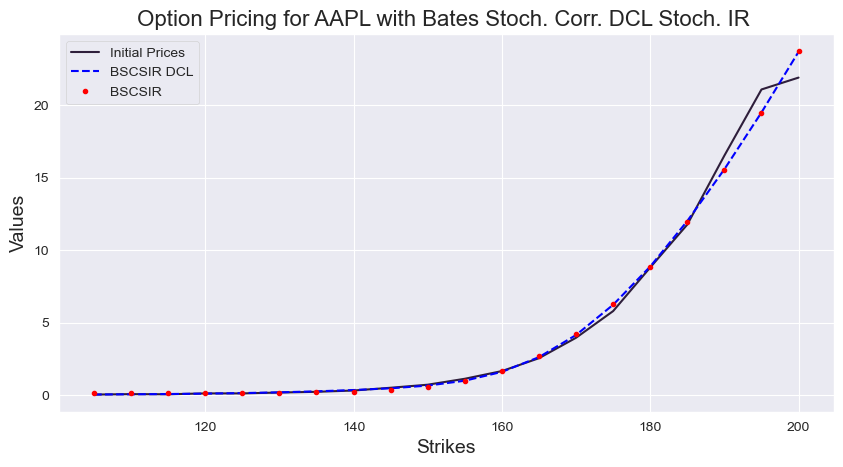

In [47]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS_DCL, '--', color='blue', label='BSCSIR DCL')
plt.plot(K, valCOS, '.', color='red', label='BSCSIR')
        
plt.title('Option Pricing for AAPL with Bates Stoch. Corr. DCL Stoch. IR ', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [43]:
list_params = np.array([v0, k, gamma, vb, kr, gammar, mur, krho, delta, rho4, rho5, muJ, sigmaJ, r0, rho0, xip])
pd.DataFrame(list_params.reshape(1, -1), columns=['v0', 'k', 'gamma', 'vb', 'kr', 'gammar', 'mur', 'krho', 'delta', 'rho4', 'rho5', 'muJ', 'sigmaJ', 'r0', 'rho0', 'xip'])

,v0,k,gamma,vb,kr,gammar,mur,krho,delta,rho4,rho5,muJ,sigmaJ,r0,rho0,xip
0,0.134628,4.974528,0.7,0.029436,0.206963,0.026358,0.197984,1.999245,1.500015,0.100139,0.432366,-2.28317,-3.385876,0.29937,0.531443,0.001246


# TSLA Options

In [103]:
tsla = ops.get_calls("TSLA", 'May 13, 2022')

In [111]:
# tsla.to_csv('tsla_option_call_may_13_2022.csv')

In [115]:
# s0_tsla = 766.37 #15.03.2022
tslaticker = yf.Ticker('TSLA')
s0_tsla = tslaticker.history().iloc[-1, 3]
s0_tsla

975.9299926757812

In [116]:
tsla_strikes = tsla.loc[:, 'Strike']
tsla_market_price = tsla.loc[:, 'Last Price']

In [117]:
tsla.head()

,Contract Name,Last Trade Date,Strike,Last Price,Bid,Ask,Change,% Change,Volume,Open Interest,Implied Volatility
0,TSLA220513C00200000,2022-04-05 12:27PM EDT,200.0,891.75,0.0,0.0,0.0,-,-,3,0.00%
1,TSLA220513C00780000,2022-04-06 11:13AM EDT,780.0,269.34,0.0,0.0,0.0,-,-,1,0.00%
2,TSLA220513C00800000,2022-04-06 2:36PM EDT,800.0,261.15,0.0,0.0,0.0,-,-,2,0.00%
3,TSLA220513C00810000,2022-04-11 10:24AM EDT,810.0,203.83,0.0,0.0,0.0,-,4,4,0.00%
4,TSLA220513C00820000,2022-04-11 11:28AM EDT,820.0,182.77,0.0,0.0,0.0,-,4,9,0.00%


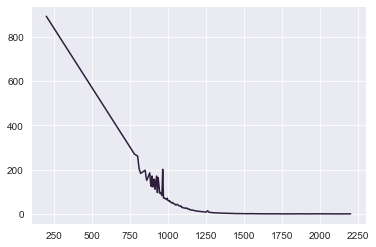

In [118]:
plt.plot(tsla_strikes, tsla_market_price)
plt.show()

In [11]:
from datetime import datetime

In [137]:
expr_date = datetime.strptime('May 13, 2022', '%B %d, %Y')
expr_date

datetime.datetime(2022, 5, 13, 0, 0)

In [138]:
today_date = datetime.now()
today_date

datetime.datetime(2022, 4, 12, 15, 52, 13, 314673)

In [139]:
maturity = expr_date - today_date
maturity = maturity.days/365.25
maturity

0.08213552361396304

In [140]:
(expr_date - today_date).days

30

In [176]:
N = 500
T = maturity
r = 0.01
rho1 = 0.2
s0 = s0_tsla

type_option = 'c'
# type_option = 'p'

In [177]:
# r, kappa, gamma, vbar, v0, rho

def error_fHM(x, prices, strikes, s0):
    cf = chf.ChFHestonModel(x[0], 1, x[1], x[2], x[3], x[4], x[5])
    
    price_calib = exm.CallPutOptionPriceCOS(cf, type_option, s0, x[0], T, strikes, N, 8).T[0]
#     errorVector = (price_calib - prices)
    errorVector = np.mean(((price_calib - prices))**2)
    
#     value = np.linalg.norm(errorVector)
    value = errorVector
    return value

In [178]:
init_vals = [0.05, 2, 0.3, 0.4, 0.3, -0.7]
bounds = ((0.001, 0.3), (0.001, 4), (0.0001, 2), (0.0001, 1.5), (0.0001, 1.5), (-0.9, 0.9))

# P0T = lambda T: np.exp(0.0012*T+0.0007) 
# s0 = 174.62

# referenceIV = np.array([48.53, 24.49, 19.23])/100.0
        
# T = 5/365.25
# referenceIV = np.array([36.76, 29.18, 27.66])/100.0
    
# frwd = s0/P0T(T)
# K = [0.4*frwd, frwd, 1.2*frwd]
# K = np.array(K).reshape([len(K),1])
      
# referenceIV = np.array(referenceIV).reshape([len(referenceIV),1])
# marketPrice = P0T(T)* exm.BS_Call_Option_Price('c', s0 / P0T(T), K, referenceIV, T, 0)


# params_heston_COS = minimize(error_fHM, x0=init_vals, args=(apple_market_price, apple_strikes, s0_apple, apple_spread),
#                              bounds=bounds, tol=1e-4, options={"maxiter": 1000})

K = tsla_strikes
marketPrice = tsla_market_price

params_heston_COS = minimize(error_fHM, x0=init_vals, args=(marketPrice, K, s0),
                             bounds=bounds, tol=1e-4, options={"maxiter": 1000})

params_heston_COS

      fun: 283.90085873956417
 hess_inv: <6x6 LbfgsInvHessProduct with dtype=float64>
      jac: array([-61.2943836 ,  24.7909553 , -10.6235462 , 240.83846041,
       436.39720381,  -5.74447086])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 140
      nit: 15
     njev: 20
   status: 0
  success: True
        x: array([ 0.04357717,  0.80291941,  1.32503566,  0.10917969,  0.01945136,
       -0.49928127])

In [179]:
np.sqrt(params_heston_COS.fun)

16.849357813862348

In [180]:
r, kappa, gamma, vbar, v0, rho = params_heston_COS.x

In [181]:
cf = chf.ChFHestonModel(r, 1, kappa, gamma, vbar, v0, rho)
option_heston_cos = exm.CallPutOptionPriceCOS(cf, type_option, s0, r, T, K, N, 10).T[0]

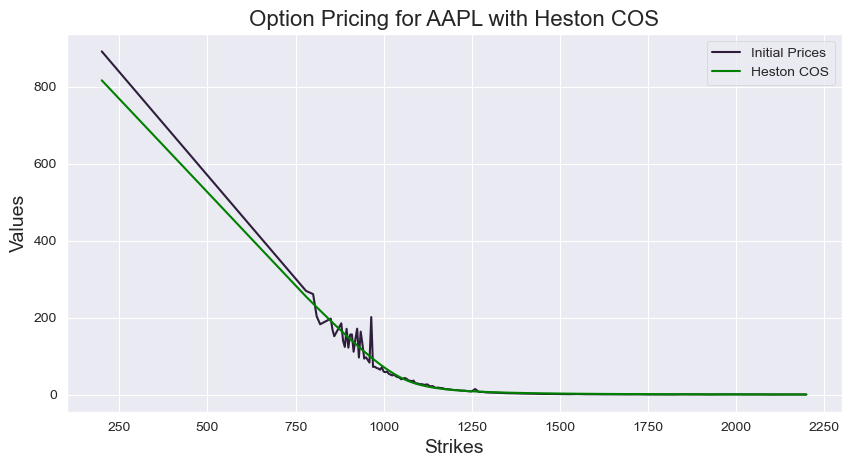

In [182]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, option_heston_cos, color='green', label='Heston COS')
        
plt.title('Option Pricing for AAPL with Heston COS', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [183]:
T = maturity
tau = T

xip = 1
type_option = 'c'

P0T = lambda T: np.exp(0.05*T)

# dt = 0.0001 
# # P0T = lambda T: np.exp(0.0012*T+0.0007) 
# f0T = lambda t: - (np.log(P0T(t+dt))-np.log(P0T(t-dt)))/(2.0*dt)
# r0 = f0T(0.00001)


K = tsla_strikes

marketPrice = tsla_market_price

calibratedParms =  calibrationBates_SIR_SC(type_option, xip, K, marketPrice, s0, T, P0T)

k = calibratedParms.get('k')
gamma = calibratedParms.get('gamma')
vb = calibratedParms.get('vb')
gammar = calibratedParms.get('gammar')
mur = calibratedParms.get('mur')
murho = calibratedParms.get('murho')
sigmarho = calibratedParms.get('sigmarho')
rho4 = calibratedParms.get('rho4')
rho5 = calibratedParms.get('rho5')
v0 = calibratedParms.get('v0')
kr = calibratedParms.get('kr')
krho = calibratedParms.get('krho')
rho0 = calibratedParms.get('rho0')
r0 = calibratedParms.get('r0')
muJ = calibratedParms.get('muJ')
sigmaJ = calibratedParms.get('sigmaJ')

errorFinal = calibratedParms.get('ErrorFinal') 

      fun: 334.0854693271909
 hess_inv: <16x16 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.09894325e-01, -1.78306436e-01,  1.35173479e+01, -5.51381163e-03,
        3.58113539e-04, -1.06297193e-03, -3.69482223e-04,  1.53477231e-03,
       -7.34985406e-03,  1.04842684e+01,  8.24229574e-04, -2.33058017e-03,
       -8.19852626e-02, -4.49006166e-02, -9.86176480e-02, -2.63969467e+00])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 493
      nit: 23
     njev: 29
   status: 0
  success: True
        x: array([ 1.31651407e+00,  1.33218480e-01,  2.21763977e-02,  2.91902832e-01,
        9.72626577e-02,  1.61862735e-01,  4.62529586e-01, -1.09187943e-01,
        7.49064028e-02,  1.02161130e-03,  4.01045298e-01,  4.81361536e-01,
       -7.34367716e-01,  1.20564163e-01, -1.92715023e+00,  8.63237513e-01])


In [184]:
np.sqrt(errorFinal)

18.278005069678443

In [185]:
round(errorFinal, 9)

334.085469327

In [186]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = exm.optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L, P0T(T))

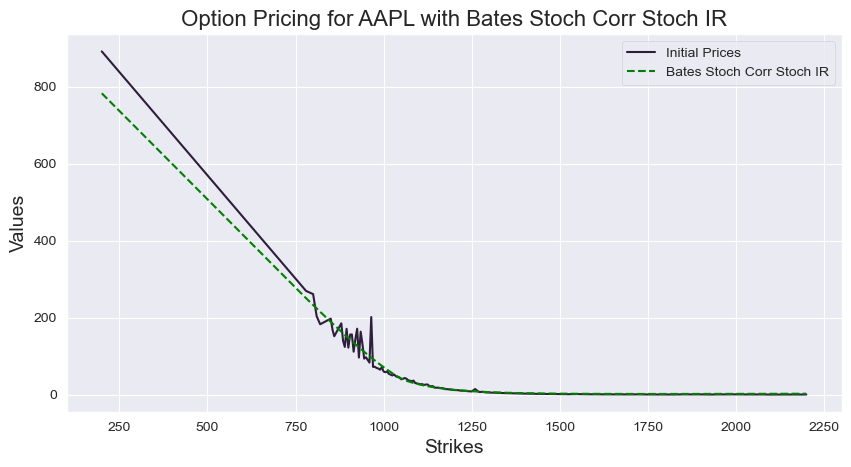

In [187]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch Corr Stoch IR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()

In [188]:
zcb0 = zcb_curve(tau, kr, mur, gammar, r0)
zcb0

0.9901780552843185

In [190]:
K*zcb0 + s0 

0      1173.965604
1      1748.268876
2      1768.072437
3      1777.974217
4      1787.875998
          ...     
110    3030.549457
111    3055.303909
112    3080.058360
113    3129.567263
114    3154.321714
Name: Strike, Length: 115, dtype: float64

In [193]:
#Zero-coupon parity
def optionPriceCOSMthd_StochIR(cf, CP, s0,tau,K,N,L,P0T):
    if K is not np.array:
        K = np.array(K).reshape([len(K),1])

    i = complex(0.0,1.0)
    x0 = np.log(s0 / K)

    # Truncation domain
    a = 0.0 - L * np.sqrt(tau)
    b = 0.0 + L * np.sqrt(tau)

    # Summation from k = 0 to k=N-1
    k = np.linspace(0,N-1,N).reshape([N,1])
    u = k * np.pi / (b - a)

    H_k = exm.Hk_Coefficients('p',a,b,k)
    mat = np.exp(i * np.outer((x0 - a) , u))
    temp = cf(u) * H_k
    temp[0] = 0.5 * temp[0]
    value = K * np.real(mat.dot(temp))
        
    if CP == 'c':
        value = value + s0 - K * P0T  

    return value

In [194]:
L = 10
N = 500

cf = chf.ChFBates_StochIR_StochCor(tau, T, k, gamma, vb, kr, gammar, mur, krho, murho, sigmarho, rho4, rho5, xip, muJ, sigmaJ, v0, r0, rho0)
valCOS = optionPriceCOSMthd_StochIR(cf, type_option, s0, T, K, N, L, zcb0)

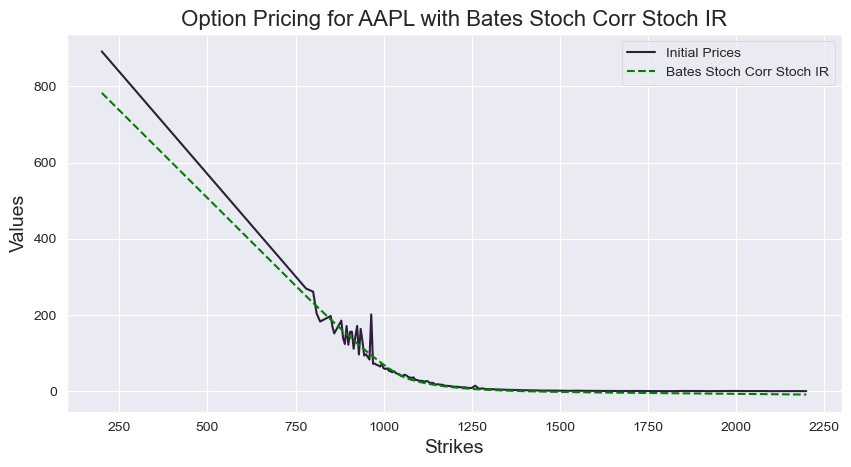

In [195]:
plt.subplots(figsize=(10, 5), dpi=100)

plt.plot(K, marketPrice, label='Initial Prices')
plt.plot(K, valCOS, '--', color='green', label='Bates Stoch Corr Stoch IR')
        
plt.title('Option Pricing for AAPL with Bates Stoch Corr Stoch IR', fontsize=16)
plt.xlabel('Strikes', fontsize=14)
plt.ylabel('Values', fontsize=14)
plt.legend()
plt.show()